<a href="https://colab.research.google.com/github/2303a51852/Python-for-DataScience/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==== Setup ====
!pip -q install imbalanced-learn xgboost >/dev/null

import os
import numpy as np
import pandas as pd
from pathlib import Path

# Modeling & evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# ==== Paths ====
DATA_PATHS = [
    "/content/Healthcare-Diabetes.csv",   # Colab
    "/content/Healthcare-Diabetes.csv"   # local upload
]
DATA_PATH = next((p for p in DATA_PATHS if Path(p).exists()), DATA_PATHS[0])
print(f"Using dataset path: {DATA_PATH}")

# ==== Load data ====
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
display(df.head())

# ==== Detect target column ====
CANDIDATES = ["Outcome", "outcome", "diabetes", "Diabetes", "class", "target"]
TARGET = None
for c in CANDIDATES:
    if c in df.columns:
        TARGET = c
        break
if TARGET is None:
    TARGET = df.columns[-1]

print("Target column:", TARGET)

# Encode if categorical
if df[TARGET].dtype == 'object':
    df[TARGET] = df[TARGET].astype('category').cat.codes

# Replace biologically implausible zeros with NaN
zero_as_missing_cols = [c for c in df.columns if c.lower() in
                        ["glucose","bloodpressure","skinthickness","insulin","bmi"] and c != TARGET]
for c in zero_as_missing_cols:
    if c in df.columns:
        df[c] = df[c].replace(0, np.nan)

# Separate features/target
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Identify numeric/categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocessors
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# ==== Train/test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ==== Define models ====
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "SVM (RBF)": SVC(probability=True, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "GaussianNB": GaussianNB()
}
if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
        eval_metric="logloss", random_state=42
    )

# ==== Helper: evaluate model ====
def evaluate_model(name, pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    try:
        y_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan

    print(f"\n=== {name} ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if not np.isnan(auc):
        print(f"ROC-AUC: {auc:.4f}")

    return {
        "model": name,
        "accuracy": (y_pred == y_test).mean(),
        "roc_auc": auc
    }

# ==== Cross-validation ====
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==== Run models (with/without SMOTE) ====
results = []
for name, clf in models.items():
    # No-SMOTE
    pipe = Pipeline([("preprocess", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    res = evaluate_model(name + " | No-SMOTE", pipe, X_test, y_test)
    results.append(res)

    # SMOTE
    smote_pipe = ImbPipeline([
        ("pre_impute", ColumnTransformer([
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", SimpleImputer(strategy="most_frequent"), cat_cols)
        ])),
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler(with_mean=False) if cat_cols else StandardScaler()),
        ("clf", clf)
    ])
    smote_pipe.fit(X_train, y_train)
    res2 = evaluate_model(name + " | SMOTE", smote_pipe, X_test, y_test)
    results.append(res2)

# ==== Consolidated results ====
res_df = pd.DataFrame(results)
display(res_df.sort_values(by="roc_auc", ascending=False))

# Save results
res_df.to_csv("/content/supervised_results_summary.csv", index=False)
print("Results saved to /content/supervised_results_summary.csv")


Using dataset path: /content/Healthcare-Diabetes.csv
Data shape: (2768, 10)


,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


Target column: Outcome

=== LogisticRegression | No-SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0     0.8222    0.7841    0.8027       454
           1     0.6216    0.6765    0.6479       238

    accuracy                         0.7471       692
   macro avg     0.7219    0.7303    0.7253       692
weighted avg     0.7532    0.7471    0.7495       692

Confusion Matrix:
 [[356  98]
 [ 77 161]]
ROC-AUC: 0.8120

=== LogisticRegression | SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0     0.8235    0.7709    0.7964       454
           1     0.6105    0.6849    0.6455       238

    accuracy                         0.7413       692
   macro avg     0.7170    0.7279    0.7210       692
weighted avg     0.7503    0.7413    0.7445       692

Confusion Matrix:
 [[350 104]
 [ 75 163]]
ROC-AUC: 0.8097

=== SVM (RBF) | No-SMOTE ===
Classification Report:
              precision    recall

,model,accuracy,roc_auc
8,RandomForest | No-SMOTE,0.988439,0.999398
9,RandomForest | SMOTE,0.988439,0.999153
14,XGBoost | No-SMOTE,0.956647,0.994290
15,XGBoost | SMOTE,0.955202,0.992837
6,DecisionTree | No-SMOTE,0.985549,0.982990
7,DecisionTree | SMOTE,0.976879,0.977381
10,GradientBoosting | No-SMOTE,0.864162,0.941001
11,GradientBoosting | SMOTE,0.856936,0.922889
5,KNN | SMOTE,0.799133,0.899636
4,KNN | No-SMOTE,0.809249,0.892774


Results saved to /content/supervised_results_summary.csv


Target column (for evaluation only): Outcome
Explained variance ratio (2 PCs): [0.23255933 0.19273374]


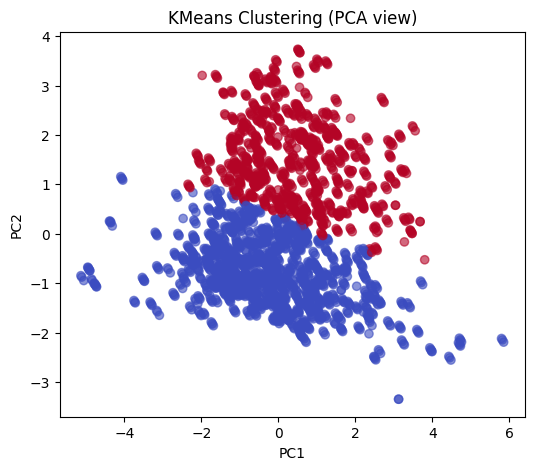

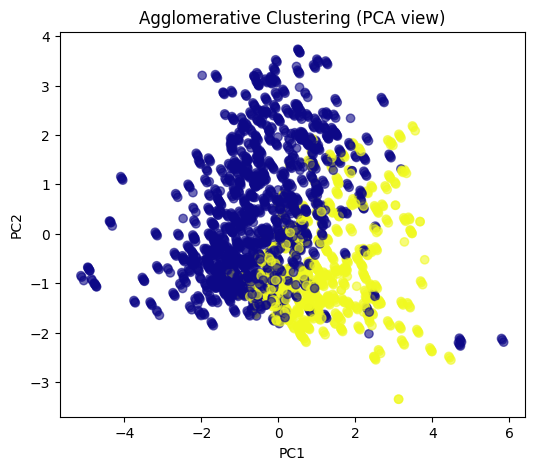

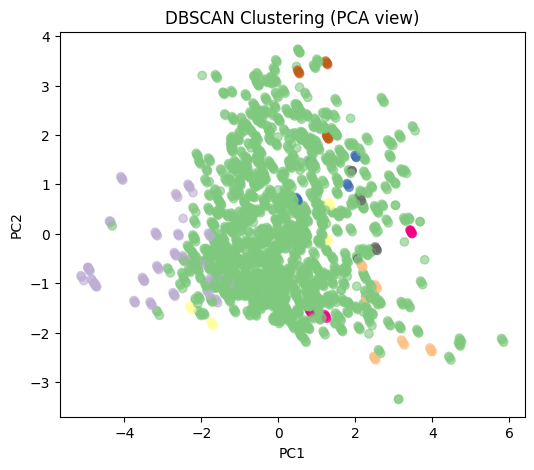

,Algorithm,Silhouette,ARI vs true
0,KMeans,0.168565,0.120024
1,Agglomerative,0.098408,0.038053
2,DBSCAN,-0.063864,0.103200


Results saved to /content/unsupervised_results_summary.csv


In [3]:
# ==== Unsupervised Learning: Clustering Analysis ====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix

# ==== Load data ====
DATA_PATH = "/content/Healthcare-Diabetes.csv"  # adjust if needed
df = pd.read_csv(DATA_PATH)

# Auto-detect target
CANDIDATES = ["Outcome", "outcome", "diabetes", "Diabetes", "class", "target"]
TARGET = None
for c in CANDIDATES:
    if c in df.columns:
        TARGET = c
        break
if TARGET is None:
    TARGET = df.columns[-1]

print("Target column (for evaluation only):", TARGET)

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio (2 PCs):", pca.explained_variance_ratio_)

# ==== Run clustering algorithms ====
results = []

# 1. KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)
results.append({
    "Algorithm": "KMeans",
    "Silhouette": silhouette_score(X_scaled, k_labels),
    "ARI vs true": adjusted_rand_score(y, k_labels)
})
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=k_labels, cmap="coolwarm", alpha=0.6)
plt.title("KMeans Clustering (PCA view)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# 2. Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=2)
a_labels = agg.fit_predict(X_scaled)
results.append({
    "Algorithm": "Agglomerative",
    "Silhouette": silhouette_score(X_scaled, a_labels),
    "ARI vs true": adjusted_rand_score(y, a_labels)
})
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=a_labels, cmap="plasma", alpha=0.6)
plt.title("Agglomerative Clustering (PCA view)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# 3. DBSCAN
db = DBSCAN(eps=1.5, min_samples=5)
d_labels = db.fit_predict(X_scaled)
sil = silhouette_score(X_scaled, d_labels) if len(set(d_labels))>1 else np.nan
results.append({
    "Algorithm": "DBSCAN",
    "Silhouette": sil,
    "ARI vs true": adjusted_rand_score(y, d_labels)
})
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=d_labels, cmap="Accent", alpha=0.6)
plt.title("DBSCAN Clustering (PCA view)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# ==== Summary table ====
res_df = pd.DataFrame(results)
display(res_df)

# Save summary
res_df.to_csv("/content/unsupervised_results_summary.csv", index=False)
print("Results saved to /content/unsupervised_results_summary.csv")


In [4]:
# ==== Reinforcement Learning for Diabetes Prediction ====
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Deep RL
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# ==== Load data ====
DATA_PATH = "/content/Healthcare-Diabetes.csv"
df = pd.read_csv(DATA_PATH)

# Target
CANDIDATES = ["Outcome","outcome","diabetes","Diabetes","class","target"]
TARGET = None
for c in CANDIDATES:
    if c in df.columns:
        TARGET = c
        break
if TARGET is None:
    TARGET = df.columns[-1]

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

# Scale
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== Discretize states with KMeans (for tabular RL) ====
n_states = 30
kmeans = KMeans(n_clusters=n_states, random_state=42, n_init=10).fit(X_train_scaled)
train_states = kmeans.predict(X_train_scaled)
test_states = kmeans.predict(X_test_scaled)

# ==== Simple environment ====
class SimpleEnv:
    def __init__(self, states, labels):
        self.states = states
        self.labels = labels
        self.n = len(labels)
    def sample(self):
        i = random.randrange(self.n)
        return int(self.states[i]), int(self.labels[i])

# ==== Q-Learning ====
def q_learning(states, labels, n_states, episodes=20000, alpha=0.1, gamma=0.95, eps=0.05):
    Q = np.zeros((n_states, 2))
    env = SimpleEnv(states, labels)
    for ep in range(episodes):
        s, true = env.sample()
        a = random.choice([0,1]) if random.random() < eps else np.argmax(Q[s])
        r = 1 if a==true else -1
        s_next, _ = env.sample()
        Q[s,a] += alpha * (r + gamma*np.max(Q[s_next]) - Q[s,a])
    return Q

# ==== SARSA ====
def sarsa(states, labels, n_states, episodes=20000, alpha=0.1, gamma=0.95, eps=0.05):
    Q = np.zeros((n_states, 2))
    env = SimpleEnv(states, labels)
    for ep in range(episodes):
        s, true = env.sample()
        a = random.choice([0,1]) if random.random()<eps else np.argmax(Q[s])
        s_next, true_next = env.sample()
        a_next = random.choice([0,1]) if random.random()<eps else np.argmax(Q[s_next])
        r = 1 if a==true else -1
        Q[s,a] += alpha*(r + gamma*Q[s_next,a_next] - Q[s,a])
    return Q

print("Training Q-Learning & SARSA...")
Q_q = q_learning(train_states, y_train.values, n_states, episodes=25000, alpha=0.2)
Q_s = sarsa(train_states, y_train.values, n_states, episodes=25000, alpha=0.2)

# Evaluate
preds_q = np.argmax(Q_q, axis=1)[test_states]
preds_s = np.argmax(Q_s, axis=1)[test_states]
acc_q = accuracy_score(y_test, preds_q)
acc_s = accuracy_score(y_test, preds_s)
print("Q-Learning Accuracy:", acc_q)
print("SARSA Accuracy:", acc_s)

# ==== DQN ====
class ReplayBuffer:
    def __init__(self): self.S=[]; self.A=[]; self.R=[]
    def add(self, s,a,r): self.S.append(s); self.A.append(a); self.R.append(r)
    def sample(self, batch=128):
        idx = np.random.choice(len(self.S), size=min(batch,len(self.S)), replace=False)
        return np.array([self.S[i] for i in idx]), np.array([self.A[i] for i in idx]), np.array([self.R[i] for i in idx])

# Build DQN
def build_dqn(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inp)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(2, activation='linear')(x)
    model = models.Model(inp,out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    return model

# Fill replay with supervised signals
replay = ReplayBuffer()
for i in range(len(X_train_scaled)):
    s = X_train_scaled[i].astype(np.float32)
    t = int(y_train.values[i])
    replay.add(s, 0, 1 if t==0 else -1)
    replay.add(s, 1, 1 if t==1 else -1)

# Train DQN
dqn = build_dqn(X_train_scaled.shape[1])
for epoch in range(30):
    S,A,R = replay.sample(batch=256)
    Qvals = dqn.predict(S, verbose=0)
    for i,a in enumerate(A):
        Qvals[i,a] = R[i]
    dqn.train_on_batch(S, Qvals)

# Evaluate DQN
Qtest = dqn.predict(X_test_scaled, verbose=0)
preds_dqn = np.argmax(Qtest, axis=1)
acc_dqn = accuracy_score(y_test, preds_dqn)
print("DQN Accuracy:", acc_dqn)

# ==== Summary ====
rl_summary = pd.DataFrame([
    {"Algorithm":"Q-Learning", "Accuracy":acc_q},
    {"Algorithm":"SARSA", "Accuracy":acc_s},
    {"Algorithm":"DQN", "Accuracy":acc_dqn}
])
display(rl_summary)

rl_summary.to_csv("/content/reinforcement_results_summary.csv", index=False)
print("Saved results to /content/reinforcement_results_summary.csv")


Training Q-Learning & SARSA...
Q-Learning Accuracy: 0.7095375722543352
SARSA Accuracy: 0.7138728323699421
DQN Accuracy: 0.708092485549133


,Algorithm,Accuracy
0,Q-Learning,0.709538
1,SARSA,0.713873
2,DQN,0.708092


Saved results to /content/reinforcement_results_summary.csv


In [5]:
# ================================
# Master ML Pipeline for Diabetes Dataset
# Supervised + Unsupervised + Reinforcement
# ================================

!pip -q install imbalanced-learn xgboost tensorflow==2.13.0 >/dev/null

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, silhouette_score, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

# TensorFlow for DQN
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# ==== Load dataset ====
DATA_PATHS = [
    "/content/Healthcare-Diabetes.csv",
    "/mnt/data/Healthcare-Diabetes.csv"
]
DATA_PATH = next((p for p in DATA_PATHS if Path(p).exists()), DATA_PATHS[0])
print("Using:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)

# ==== Detect target ====
CANDIDATES = ["Outcome","outcome","diabetes","Diabetes","class","target"]
TARGET = None
for c in CANDIDATES:
    if c in df.columns:
        TARGET = c
        break
if TARGET is None:
    TARGET = df.columns[-1]
print("Target:", TARGET)

# Encode categorical target
if df[TARGET].dtype == 'object':
    df[TARGET] = df[TARGET].astype('category').cat.codes

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# ==== Preprocessing ====
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])
preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

# ================================
# 1. SUPERVISED LEARNING
# ================================
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "GaussianNB": GaussianNB()
}
if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9,
        eval_metric="logloss", random_state=42
    )

sup_results = []
for name, clf in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    try:
        y_proba = pipe.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = np.nan
    sup_results.append({"Algorithm": name, "Accuracy": accuracy_score(y_test,y_pred), "ROC-AUC": auc})

sup_df = pd.DataFrame(sup_results)
print("\nSupervised Results:")
display(sup_df)

# ================================
# 2. UNSUPERVISED LEARNING
# ================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

unsup_results = []

# KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)
unsup_results.append({
    "Algorithm":"KMeans",
    "Silhouette": silhouette_score(X_scaled, k_labels),
    "ARI vs True": adjusted_rand_score(y, k_labels)
})

# Agglomerative
agg = AgglomerativeClustering(n_clusters=2)
a_labels = agg.fit_predict(X_scaled)
unsup_results.append({
    "Algorithm":"Agglomerative",
    "Silhouette": silhouette_score(X_scaled, a_labels),
    "ARI vs True": adjusted_rand_score(y, a_labels)
})

# DBSCAN
db = DBSCAN(eps=1.5, min_samples=5)
d_labels = db.fit_predict(X_scaled)
sil = silhouette_score(X_scaled, d_labels) if len(set(d_labels))>1 else np.nan
unsup_results.append({
    "Algorithm":"DBSCAN",
    "Silhouette": sil,
    "ARI vs True": adjusted_rand_score(y, d_labels)
})

unsup_df = pd.DataFrame(unsup_results)
print("\nUnsupervised Results:")
display(unsup_df)

# ================================
# 3. REINFORCEMENT LEARNING
# ================================
# RL environment: state=features, action=predict class
X_train_s, X_test_s = StandardScaler().fit_transform(X_train), StandardScaler().fit_transform(X_test)

# Cluster for tabular RL
n_states = 30
kmeans_rl = KMeans(n_clusters=n_states, random_state=42, n_init=10).fit(X_train_s)
train_states = kmeans_rl.predict(X_train_s)
test_states = kmeans_rl.predict(X_test_s)

class SimpleEnv:
    def __init__(self, states, labels):
        self.states=states; self.labels=labels; self.n=len(labels)
    def sample(self):
        i=random.randrange(self.n)
        return int(self.states[i]), int(self.labels[i])

def q_learning(states, labels, n_states, episodes=20000, alpha=0.1, gamma=0.95, eps=0.05):
    Q = np.zeros((n_states,2))
    env = SimpleEnv(states, labels)
    for _ in range(episodes):
        s, true = env.sample()
        a = random.choice([0,1]) if random.random()<eps else np.argmax(Q[s])
        r = 1 if a==true else -1
        s2,_ = env.sample()
        Q[s,a]+=alpha*(r+gamma*np.max(Q[s2])-Q[s,a])
    return Q

def sarsa(states, labels, n_states, episodes=20000, alpha=0.1, gamma=0.95, eps=0.05):
    Q=np.zeros((n_states,2))
    env=SimpleEnv(states, labels)
    for _ in range(episodes):
        s,true=env.sample()
        a=random.choice([0,1]) if random.random()<eps else np.argmax(Q[s])
        s2,true2=env.sample()
        a2=random.choice([0,1]) if random.random()<eps else np.argmax(Q[s2])
        r=1 if a==true else -1
        Q[s,a]+=alpha*(r+gamma*Q[s2,a2]-Q[s,a])
    return Q

print("\nTraining RL agents...")
Qq = q_learning(train_states,y_train.values,n_states,episodes=25000,alpha=0.2)
Qs = sarsa(train_states,y_train.values,n_states,episodes=25000,alpha=0.2)

preds_q = np.argmax(Qq, axis=1)[test_states]
preds_s = np.argmax(Qs, axis=1)[test_states]
acc_q = accuracy_score(y_test, preds_q)
acc_s = accuracy_score(y_test, preds_s)

# Deep Q Network
class ReplayBuffer:
    def __init__(self): self.S=[]; self.A=[]; self.R=[]
    def add(self,s,a,r): self.S.append(s); self.A.append(a); self.R.append(r)
    def sample(self,b=128):
        idx=np.random.choice(len(self.S),size=min(b,len(self.S)),replace=False)
        return np.array([self.S[i] for i in idx]), np.array([self.A[i] for i in idx]), np.array([self.R[i] for i in idx])

replay=ReplayBuffer()
for i in range(len(X_train_s)):
    s=X_train_s[i].astype(np.float32); t=int(y_train.values[i])
    replay.add(s,0,1 if t==0 else -1); replay.add(s,1,1 if t==1 else -1)

def build_dqn(input_dim):
    inp=layers.Input(shape=(input_dim,))
    x=layers.Dense(64,activation="relu")(inp)
    x=layers.Dense(64,activation="relu")(x)
    out=layers.Dense(2,activation="linear")(x)
    model=tf.keras.models.Model(inp,out) # Fixed: Use tf.keras.models.Model
    model.compile(optimizer=optimizers.Adam(1e-3),loss="mse")
    return model

dqn=build_dqn(X_train_s.shape[1])
for epoch in range(30):
    S,A,R=replay.sample(256)
    Qvals=dqn.predict(S,verbose=0)
    for i,a in enumerate(A):
        Qvals[i,a]=R[i]
    dqn.train_on_batch(S,Qvals)

Qtest=dqn.predict(X_test_s,verbose=0)
preds_dqn=np.argmax(Qtest,axis=1)
acc_dqn=accuracy_score(y_test, preds_dqn)
print("DQN Accuracy:", acc_dqn)

# ==== Summary ====
rl_summary = pd.DataFrame([
    {"Algorithm":"Q-Learning", "Accuracy":acc_q},
    {"Algorithm":"SARSA", "Accuracy":acc_s},
    {"Algorithm":"DQN", "Accuracy":acc_dqn}
])
display(rl_summary)

rl_summary.to_csv("/content/reinforcement_results_summary.csv", index=False)
print("Saved results to /content/reinforcement_results_summary.csv")

ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.0
Using: /content/Healthcare-Diabetes.csv
Shape: (2768, 10)
Target: Outcome

Supervised Results:


,Algorithm,Accuracy,ROC-AUC
0,LogisticRegression,0.738439,0.820485
1,SVM,0.804913,0.872635
2,KNN,0.791908,0.876708
3,DecisionTree,0.988439,0.989190
4,RandomForest,0.988439,0.999250
5,GradientBoosting,0.854046,0.933264
6,GaussianNB,0.747110,0.797801
7,XGBoost,0.913295,0.978140



Unsupervised Results:


,Algorithm,Silhouette,ARI vs True
0,KMeans,0.168565,0.120024
1,Agglomerative,0.098408,0.038053
2,DBSCAN,-0.063864,0.103200



Training RL agents...
DQN Accuracy: 0.7384393063583815


,Algorithm,Accuracy
0,Q-Learning,0.699422
1,SARSA,0.703757
2,DQN,0.738439


Saved results to /content/reinforcement_results_summary.csv
